In [1]:
ckpts_xx = []
ckpt1 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_Triplet_C_breakHis1_daug_2l1**1.5beta_00011.t7'
ckpts_xx.append(ckpt1)
ckpt2 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_Triplet_C_breakHis2_daug_2l1**1.5beta_00012.t7'
ckpts_xx.append(ckpt2)
ckpt3 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_Triplet_C_breakHis3_daug_2l1**1.5beta_00011.t7'
ckpts_xx.append(ckpt3)
ckpt4 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_Triplet_C_breakHis4_daug_2l1**1.5beta_00015.t7'
ckpts_xx.append(ckpt4)
ckpt5 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_Triplet_C_breakHis5_daug_2l1**1.5beta_00011.t7'
ckpts_xx.append(ckpt5)

ckpts_ce = []
ckpt1 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_triplet_c_breakHis1_daug_focal0alpha_00008.t11'
ckpts_ce.append(ckpt1)
ckpt2 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_triplet_c_breakHis2_daug_focal0alpha_00005.t11'
ckpts_ce.append(ckpt2)
ckpt3 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_triplet_c_breakHis3_daug_focal0alpha_00031.t11'
ckpts_ce.append(ckpt3)
ckpt4 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_triplet_c_breakHis4_daug_focal0alpha_00007.t11'
ckpts_ce.append(ckpt4)
ckpt5 = '/mnt/DATA_OTHER/breakHis/results/checkpoint/breakHis/ckpt_baseline_triplet_c_breakHis5_daug_focal0alpha_00005.t11'
ckpts_ce.append(ckpt5)

In [ ]:
ckpts_xx

In [2]:
import os
import torch
from torchvision import transforms
from datasets import BreakHisPIL
from networks import TripletClassificationNet, BreakHisEmbeddingNet
from googlenet import InceptionEmbeddingBreakHis
from resnet import ResNet18

from evaluation import *
from save_load import *

from losses import TripletClassificationLoss
from metrics import TripletAccumulatedAccuracyMetric

from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
def get_scores(model, dataloader, cuda):
    scores = []
    for batch_idx, (data, target, _) in enumerate(dataloader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        outputs = model.get_classification(*data)
        scores.append(outputs.detach().cpu())
    
    return torch.cat(scores,0).numpy()

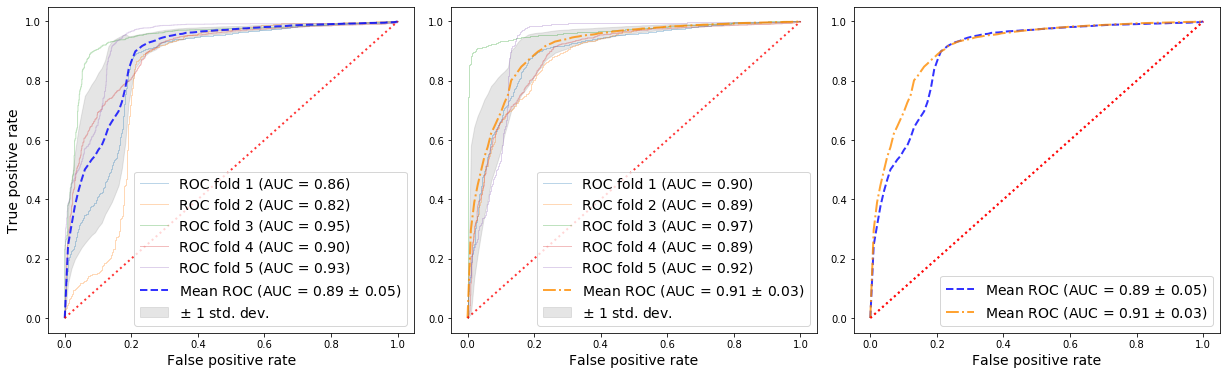

In [5]:
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(21,6))
ax1 = plt.subplot(131)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
ax2 = plt.subplot(132)
plt.xlabel('False positive rate', fontsize=14)
# plt.ylabel('True positive rate', fontsize=14)
ax3 = plt.subplot(133)
plt.xlabel('False positive rate', fontsize=14)
# plt.ylabel('True positive rate', fontsize=14)

tprs = []
aucs = []

for i in range(1,6):
    fold = i
    ptest = '/mnt/DATA_OTHER/breakHis/mkfold/fold%d/test/'%fold
    test_dataset = BreakHisPIL(ptest, data_aug = False, transform=transforms.Compose([
                                    transforms.ToTensor()

                                 ]))
    y = test_dataset.labels
    n_classes = len(test_dataset.labels_set)

    cuda = torch.cuda.is_available()
    batch_size = 20
    kwargs = {'num_workers': 3, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    margin = 1
    embedding_net = BreakHisEmbeddingNet(n_classes)
    model = TripletClassificationNet(embedding_net, n_classes)
    if cuda:
        model.cuda()
    model.eval()
    
    model=load_model_ckpt_w(model, ckpts_ce[i-1])
    scores = get_scores(model, test_loader, cuda)

    fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,1], pos_label=1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    auc=metrics.roc_auc_score(y, scores[:,1])
    aucs.append(auc)
    
    ax1.plot(fpr, tpr,
        label=r'ROC fold %d (AUC = %0.2f)' % (i, auc),
        lw=1, alpha=.3)
    
a = './results'
np.save(os.path.join(a, 'tprs_ce.npy'), np.array(tprs))
np.save(os.path.join(a, 'aucs_ce.npy'), np.array(aucs))

mean_tpr = np.mean(np.array(tprs),0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax1.plot(mean_fpr, mean_tpr, linestyle='dashed', color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

ax3.plot(mean_fpr, mean_tpr, linestyle='dashed',  color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax3.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax1.xlim=[-0.05, 1.05]
ax1.ylim=[-0.05, 1.05]
ax1.legend(loc="lower right", prop={'size': 14})
# ax1.ylabel('True positive rate')

tprs = []
aucs = []

for i in range(1,6):
    fold = i
    ptest = '/mnt/DATA_OTHER/breakHis/mkfold/fold%d/test/'%fold
    test_dataset = BreakHisPIL(ptest, data_aug = False, transform=transforms.Compose([
                                    transforms.ToTensor()

                                 ]))
    y = test_dataset.labels
    n_classes = len(test_dataset.labels_set)

    cuda = torch.cuda.is_available()
    batch_size = 20
    kwargs = {'num_workers': 3, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    margin = 1
    embedding_net = BreakHisEmbeddingNet(n_classes)
    model = TripletClassificationNet(embedding_net, n_classes)
    if cuda:
        model.cuda()
    model.eval()
    
    model=load_model_ckpt_w(model, ckpts_xx[i-1])
    scores = get_scores(model, test_loader, cuda)

    fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,1], pos_label=1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    auc=metrics.roc_auc_score(y, scores[:,1])
    aucs.append(auc)
    
    ax2.plot(fpr, tpr,
        label=r'ROC fold %d (AUC = %0.2f)' % (i, auc),
        lw=1, alpha=.3)
    
a = './results'
np.save(os.path.join(a, 'tprs_xx.npy'), np.array(tprs))
np.save(os.path.join(a, 'aucs_xx.npy'), np.array(aucs))

mean_tpr = np.mean(np.array(tprs),0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax2.plot(mean_fpr, mean_tpr, linestyle='dashdot', color='darkorange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax2.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

ax3.plot(mean_fpr, mean_tpr, linestyle='dashdot', color='darkorange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax3.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax2.xlim=[-0.05, 1.05]
ax2.ylim=[-0.05, 1.05]
ax2.legend(loc="lower right", prop={'size': 14})
# ax2.ylabel('True positive rate')

ax3.xlim=[-0.05, 1.05]
ax3.ylim=[-0.05, 1.05]
ax3.legend(loc="lower right", prop={'size': 14})
# ax3.xlabel('False positive rate')
# ax3.ylabel('True positive rate')


plt.subplots_adjust(wspace =0.1)
plt.show()

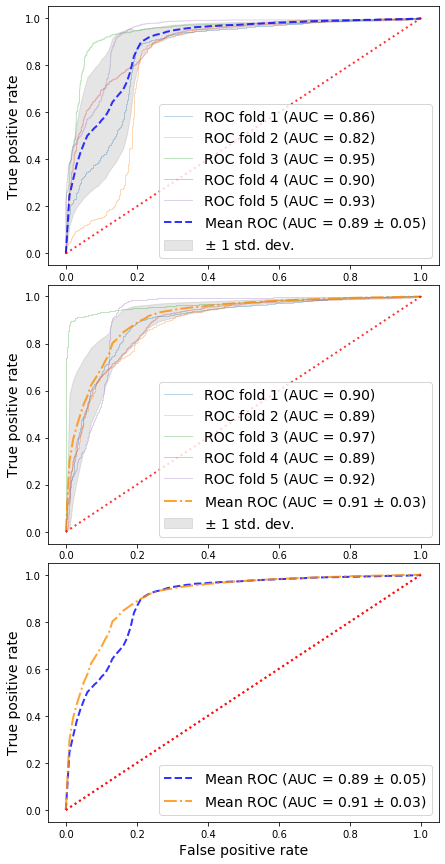

In [13]:
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(7,15))
ax1 = plt.subplot(311)
# plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
ax2 = plt.subplot(312)
# plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
ax3 = plt.subplot(313)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)

tprs = []
aucs = []

for i in range(1,6):
    fold = i
    ptest = '/mnt/DATA_OTHER/breakHis/mkfold/fold%d/test/'%fold
    test_dataset = BreakHisPIL(ptest, data_aug = False, transform=transforms.Compose([
                                    transforms.ToTensor()

                                 ]))
    y = test_dataset.labels
    n_classes = len(test_dataset.labels_set)

    cuda = torch.cuda.is_available()
    batch_size = 20
    kwargs = {'num_workers': 3, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    margin = 1
    embedding_net = BreakHisEmbeddingNet(n_classes)
    model = TripletClassificationNet(embedding_net, n_classes)
    if cuda:
        model.cuda()
    model.eval()
    
    model=load_model_ckpt_w(model, ckpts_ce[i-1])
    scores = get_scores(model, test_loader, cuda)

    fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,1], pos_label=1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    auc=metrics.roc_auc_score(y, scores[:,1])
    aucs.append(auc)
    
    ax1.plot(fpr, tpr,
        label=r'ROC fold %d (AUC = %0.2f)' % (i, auc),
        lw=1, alpha=.3)
    
a = './results'
np.save(os.path.join(a, 'tprs_ce.npy'), np.array(tprs))
np.save(os.path.join(a, 'aucs_ce.npy'), np.array(aucs))

mean_tpr = np.mean(np.array(tprs),0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax1.plot(mean_fpr, mean_tpr, linestyle='dashed', color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

ax3.plot(mean_fpr, mean_tpr, linestyle='dashed',  color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax3.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax1.xlim=[-0.05, 1.05]
ax1.ylim=[-0.05, 1.05]
ax1.legend(loc="lower right", prop={'size': 14})
# ax1.ylabel('True positive rate')

tprs = []
aucs = []

for i in range(1,6):
    fold = i
    ptest = '/mnt/DATA_OTHER/breakHis/mkfold/fold%d/test/'%fold
    test_dataset = BreakHisPIL(ptest, data_aug = False, transform=transforms.Compose([
                                    transforms.ToTensor()

                                 ]))
    y = test_dataset.labels
    n_classes = len(test_dataset.labels_set)

    cuda = torch.cuda.is_available()
    batch_size = 20
    kwargs = {'num_workers': 3, 'pin_memory': True} if cuda else {}
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    margin = 1
    embedding_net = BreakHisEmbeddingNet(n_classes)
    model = TripletClassificationNet(embedding_net, n_classes)
    if cuda:
        model.cuda()
    model.eval()
    
    model=load_model_ckpt_w(model, ckpts_xx[i-1])
    scores = get_scores(model, test_loader, cuda)

    fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,1], pos_label=1)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    auc=metrics.roc_auc_score(y, scores[:,1])
    aucs.append(auc)
    
    ax2.plot(fpr, tpr,
        label=r'ROC fold %d (AUC = %0.2f)' % (i, auc),
        lw=1, alpha=.3)
    
a = './results'
np.save(os.path.join(a, 'tprs_xx.npy'), np.array(tprs))
np.save(os.path.join(a, 'aucs_xx.npy'), np.array(aucs))

mean_tpr = np.mean(np.array(tprs),0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax2.plot(mean_fpr, mean_tpr, linestyle='dashdot', color='darkorange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax2.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

ax3.plot(mean_fpr, mean_tpr, linestyle='dashdot', color='darkorange',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax3.plot([0, 1], [0, 1], linestyle='dotted', lw=2, color='r', alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax2.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax2.xlim=[-0.05, 1.05]
ax2.ylim=[-0.05, 1.05]
ax2.legend(loc="lower right", prop={'size': 14})
# ax2.ylabel('True positive rate')

ax3.xlim=[-0.05, 1.05]
ax3.ylim=[-0.05, 1.05]
ax3.legend(loc="lower right", prop={'size': 14})
# ax3.xlabel('False positive rate')
# ax3.ylabel('True positive rate')


plt.subplots_adjust(hspace =0.075)
plt.show()

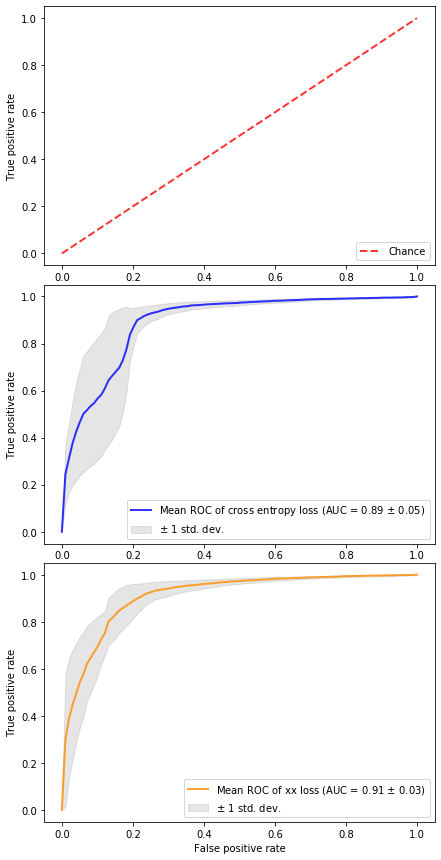

In [9]:
mean_fpr = np.linspace(0, 1, 100)
tprs_xx = np.load('./results/tprs.npy')
aucs_xx = np.load('./results/aucs.npy')
tprs_ce = np.load('./results/tprs_ce.npy')
aucs_ce = np.load('./results/aucs_ce.npy')

mean_tpr_xx = np.mean(np.array(tprs_xx),0)
mean_tpr_xx[-1] = 1.0
mean_tpr_ce = np.mean(np.array(tprs_ce),0)
mean_tpr_ce[-1] = 1.0

mean_auc_xx = metrics.auc(mean_fpr, mean_tpr_xx)
std_auc_xx = np.std(aucs_xx)
mean_auc_ce = metrics.auc(mean_fpr, mean_tpr_ce)
std_auc_ce = np.std(aucs_ce)

# fig, ax = plt.subplots(figsize=(7,5))
plt.figure(figsize=(7,15))
ax1 = plt.subplot(311)

ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.ylabel('True positive rate')

ax2 = plt.subplot(312)
ax2.plot(mean_fpr, mean_tpr_ce, color='b',
        label=r'Mean ROC of cross entropy loss (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_ce, std_auc_ce),
        lw=2, alpha=.8)

std_tpr_ce = np.std(tprs_ce, axis=0)
tprs_upper_ce = np.minimum(mean_tpr_ce + std_tpr_ce, 1)
tprs_lower_ce = np.maximum(mean_tpr_ce - std_tpr_ce, 0)


ax2.fill_between(mean_fpr, tprs_lower_ce, tprs_upper_ce, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
plt.legend(loc="lower right")
plt.ylabel('True positive rate')

ax3 = plt.subplot(313)
ax3.plot(mean_fpr, mean_tpr_xx, color='darkorange',
        label=r'Mean ROC of xx loss (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_xx, std_auc_xx),
        lw=2, alpha=.8)

std_tpr_xx = np.std(tprs_xx, axis=0)
tprs_upper_xx = np.minimum(mean_tpr_xx + std_tpr_xx, 1)
tprs_lower_xx = np.maximum(mean_tpr_xx - std_tpr_xx, 0)
ax3.fill_between(mean_fpr, tprs_lower_xx, tprs_upper_xx, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')


plt.xlim=[-0.05, 1.05]
plt.ylim=[-0.05, 1.05]
plt.legend(loc="lower right")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.subplots_adjust(hspace =0.075)
plt.show()